## Import Libraries and Data

In [35]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict


from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, matthews_corrcoef
from imblearn.over_sampling import SMOTENC

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline
RSEED=42

In [2]:
df = pd.read_csv('../data/training_new.csv')
df.head()

,ProviderId,ProductCategory,ChannelId,PricingStrategy,weekday,difference,IsDebit,Value,time_of_day,FraudResult
0,ProviderId_6,airtime,ChannelId_3,2,3,0.0,1,1000,8329,0
1,ProviderId_4,financial_services,ChannelId_2,2,3,0.0,0,20,8348,0
2,ProviderId_6,airtime,ChannelId_3,2,3,0.0,1,500,9861,0
3,ProviderId_1,utility_bill,ChannelId_3,2,3,1.0,1,21800,12775,0
4,ProviderId_4,financial_services,ChannelId_2,2,3,0.0,0,644,12861,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ProviderId       95662 non-null  object 
 1   ProductCategory  95662 non-null  object 
 2   ChannelId        95662 non-null  object 
 3   PricingStrategy  95662 non-null  int64  
 4   weekday          95662 non-null  int64  
 5   difference       95662 non-null  float64
 6   IsDebit          95662 non-null  int64  
 7   Value            95662 non-null  int64  
 8   time_of_day      95662 non-null  int64  
 9   FraudResult      95662 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 7.3+ MB


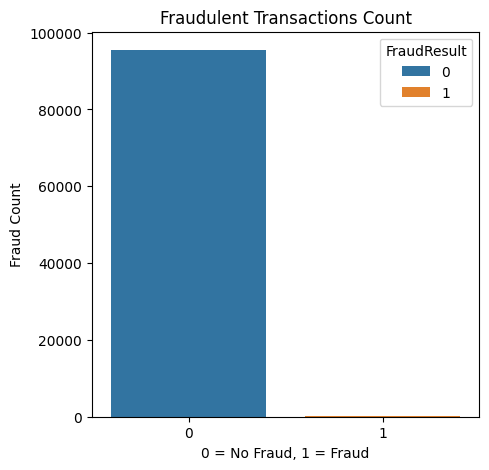

In [4]:
# plot of fraud results which are  quite imbalanced
plt.figure(figsize=(5,5))
sns.countplot(x='FraudResult',data=df, hue = "FraudResult")
plt.xlabel("0 = No Fraud, 1 = Fraud")
plt.ylabel("Fraud Count")
plt.title("Fraudulent Transactions Count")

plt.show();

In [5]:
#changing the type of features to object to correctly input them into model
df[['PricingStrategy', 'weekday', 'difference', 'IsDebit']] = df[['PricingStrategy', 'weekday', 'difference', 'IsDebit']].astype('object')

In [6]:
# Define predictors
X = df.drop('FraudResult', axis=1)

# Define target variable
y = df['FraudResult']

In [7]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED, stratify=y, test_size = .25)

## Balancing the Training Dataset

In [8]:
# change to np.array for smote
features = ["ProviderId", "ProductCategory", "ChannelId", "PricingStrategy", 
    "weekday", "difference", "IsDebit", "Value", "time_of_day"]

X_train = np.array(
    X_train[features]
    )

In [9]:
# initiate smotenc
sm = SMOTENC(categorical_features=[0, 1, 2, 3, 4, 5, 6], random_state = RSEED)
# run smotenc
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

### Plot comparing the target value data before(highly imbalanced) and after(balanced) 

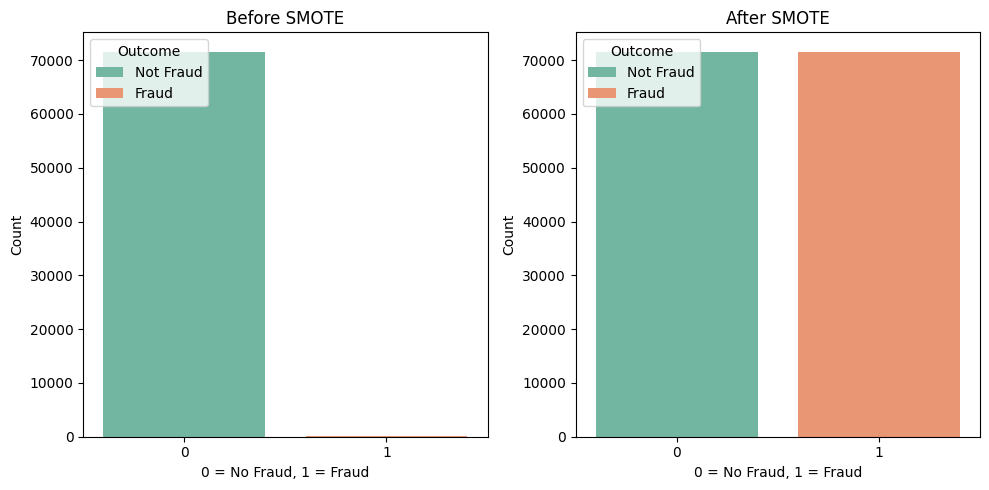

In [10]:
# Create figure with 2 subplots (side by side)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Before SMOTE
sns.countplot(
    x="FraudResult", 
    data=y_train.to_frame(name="FraudResult"), 
    hue="FraudResult", 
    ax=ax[0], 
    palette="Set2", 
    legend=False
)
ax[0].set_title("Before SMOTE")
ax[0].set_xlabel("0 = No Fraud, 1 = Fraud")
ax[0].set_ylabel("Count")
ax[0].legend(title="Outcome", loc="upper left", labels=["Not Fraud", "Fraud"])

# After SMOTE
sns.countplot(
    x="FraudResult", 
    data=y_train_sm.to_frame(name="FraudResult"), 
    hue="FraudResult", 
    ax=ax[1], 
    palette="Set2", 
    legend=False
)
ax[1].set_title("After SMOTE")
ax[1].set_xlabel("0 = No Fraud, 1 = Fraud")
ax[1].set_ylabel("Count")
ax[1].legend(title="Outcome", loc="upper left", labels=["Not Fraud", "Fraud"])

plt.tight_layout()
plt.show()

In [11]:
# transform back into a data frame
X_train_sm = pd.DataFrame(X_train_sm)

In [12]:
X_train_sm.columns = ["ProviderId", "ProductCategory", "ChannelId", "PricingStrategy", 
    "weekday", "difference", "IsDebit", "Value", "time_of_day"]
X_train_sm = X_train_sm.astype({"Value": "int32", "time_of_day": "int32"})

In [13]:
X_train_sm

,ProviderId,ProductCategory,ChannelId,PricingStrategy,weekday,difference,IsDebit,Value,time_of_day
0,ProviderId_4,financial_services,ChannelId_2,2,4,0.0,0,200,28699
1,ProviderId_4,financial_services,ChannelId_2,2,0,0.0,0,40,41786
2,ProviderId_4,financial_services,ChannelId_2,2,6,0.0,0,50,61735
3,ProviderId_6,airtime,ChannelId_3,2,0,0.0,1,1000,65871
4,ProviderId_6,airtime,ChannelId_3,2,4,0.0,1,2000,49474
...,...,...,...,...,...,...,...,...,...
143197,ProviderId_1,financial_services,ChannelId_3,2,1,0.0,1,7812988,23404
143198,ProviderId_1,financial_services,ChannelId_3,4,1,0.0,1,500000,50042
143199,ProviderId_3,financial_services,ChannelId_3,2,5,0.0,1,500000,41148
143200,ProviderId_5,financial_services,ChannelId_3,2,2,0.0,1,800000,67202


In [14]:
# distinguish between numerical and categorical features
cat_features = [
   "ProviderId", "ProductCategory", "ChannelId", "PricingStrategy", 
    "weekday", "difference", "IsDebit"
    ]
num_features = ["Value", "time_of_day"]

In [15]:
# Initiate scaler
scaler = StandardScaler()

# run scaler
scaler = scaler.fit(X_train_sm[num_features])
X_train_sm[num_features] = scaler.transform(X_train_sm[num_features])

X_test[num_features] = scaler.transform(X_test[num_features])


In [16]:
# a function to create dummy variable
def create_dummies(X, cf):
    """function to get dummy variables 

    Args:
        X (pd.frame): test or train data
        cf (string): column names of categorical data in X

    """
    # all features should be categorical
    X[cf] = X[cf].astype("category")
    # get_dummies
    dummies = pd.get_dummies(X[cf], drop_first=True)
    X = X.drop(cf, axis=1)
    X[dummies.columns] = dummies
    
    return X, dummies.columns

In [17]:
# Create dummy variables for training and test set
X_train_sm_sc, cat_features_dummies = create_dummies(X_train_sm, cat_features)
X_test_sc, cat_features = create_dummies(X_test, cat_features)

### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

# Initiate model
logreg = LogisticRegression(random_state = RSEED)
y_train_pred = logreg.fit(X_train_sm_sc, y_train_sm)
y_test_pred = logreg.predict(X_test_sc)

In [19]:
confusion_matrix(y_test, y_test_pred)

array([[23720,   148],
       [    2,    46]])

In [20]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores Logistic Regression:')
print('-------------------------')
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_pred)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_test_pred)))

Cross validation scores Logistic Regression:
-------------------------
F1-score: 0.38
MCC: 0.48


## Random forest classifier

In [21]:
# Train a Random Forest classifier

# Initiate model
rf = RandomForestClassifier(random_state=RSEED)
rf.fit(X_train_sm_sc, y_train_sm)
y_test_pred_rf = rf.predict(X_test_sc)

confusion_matrix(y_test, y_test_pred_rf)

array([[23845,    23],
       [    8,    40]])

In [22]:
# Get feature importances
rf_model = RandomForestClassifier(random_state=RSEED)
rf_model.fit(X_train_sm_sc, y_train_sm)
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

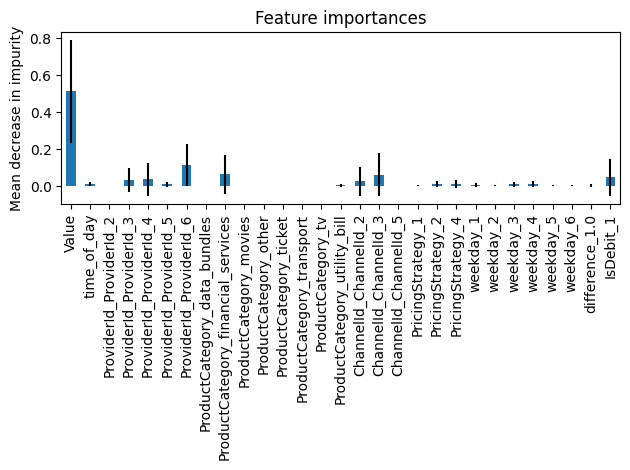

In [23]:
forest_importances = pd.Series(importances, index=X_train_sm_sc.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [24]:
# Calculating the accuracy for the RandomForest Classifier 
print('Cross validation scores Random Forest:')
print('-------------------------')
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_pred_rf)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_test_pred_rf)))

Cross validation scores Random Forest:
-------------------------
F1-score: 0.72
MCC: 0.73


## knn Classifier

In [26]:
# Train a KNN classifier

# Initiate model
knn = KNeighborsClassifier()
knn.fit(X_train_sm_sc, y_train_sm)
y_test_pred_knn = knn.predict(X_test_sc)

confusion_matrix(y_test, y_test_pred_knn)

array([[23792,    76],
       [   15,    33]])

In [29]:
# Calculating the accuracy for the KNN Classifier 
print('Cross validation scores KNN:')
print('-------------------------')
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_pred_knn)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_test_pred_knn)))


Cross validation scores KNN:
-------------------------
F1-score: 0.42
MCC: 0.45


From the trained models and F1-Scores, it is found that Random Forest Classifier performs the best among others. In next steps, best hyperparameters are to search through Random and Grid Search.

In [ ]:
########################################################
#     Random search for Random Forest classifier       #
########################################################

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_sm_sc, y_train_sm)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  37.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  39.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  39.7s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=12

/Users/rajwantkaur/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rajwantkaur/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rajwantkaur/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py", line 1356, in wrapper
    estimator._validate_params()
  File "/Users/rajwantkaur/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py", lin

,estimator,RandomForestClassifier()
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [10, 20, ...], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [36]:
##########################################################
# Get and show scores for before and after random search #
##########################################################

best_random = rf_random.best_estimator_
y_test_pred_rf_rand = best_random.predict(X_test_sc)

# RandomForest Classifier 
print('Cross validation scores for Base Random Forest:')
print('-------------------------')
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_pred_rf)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_test_pred_rf)))

# Random search RandomForest Classifier 
print('Cross validation scores after Random search Random Forest:')
print('-------------------------')
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_pred_rf_rand)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_test_pred_rf_rand)))

Cross validation scores for Base Random Forest:
-------------------------
F1-score: 0.72
MCC: 0.73
Cross validation scores after Random search Random Forest:
-------------------------
F1-score: 0.73
MCC: 0.73


In [33]:
# best parameters random search
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [40]:
###################################################
#     Grid search for Random Forest Classifier    #
###################################################

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [10,20,30],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [400, 600, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_sm_sc, y_train_sm)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=400; total time=  48.5s
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=400; total time=  52.4s
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=400; total time=  53.8s
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=600; total time= 1.2min
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=600; total time= 1.3min
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=600; total time= 1.3min
[CV] END bootstrap=False, max_depth=10, min_samples_split=5, n_estimators=400; total time=  42.9s
[CV] END bootstrap=False, max_depth=10, min_samples_split=5, n_estimators=400; total time=  46.7s
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=1000; total time= 1.9min
[CV] END bootstrap=False, max_depth=10, min_samples_spli

,estimator,RandomForestClassifier()
,param_grid,"{'bootstrap': [False], 'max_depth': [10, 20, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [400, 600, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,400


In [41]:
##########################################################
# Get and show scores for before and after random search #
##########################################################

best_grid = grid_search.best_estimator_
y_test_pred_rf_grid = best_grid.predict(X_test_sc)

# RandomForest Classifier 
print('Cross validation scores Base Forest:')
print('-------------------------')
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_pred_rf)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_test_pred_rf)))

# Random search Random Forest Classifier 
print('Cross validation scores Random search Random Forest:')
print('-------------------------')
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_pred_rf_rand)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_test_pred_rf_rand)))

# Grid search Random Forest Classifier 
print('Cross validation scores Grid search Random Forest:')
print('-------------------------')
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_pred_rf_grid)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_test_pred_rf_grid)))

print('Best parameters random search:')
print('-------------------------')
print(rf_random.best_params_)

print('Best parameters grid search:')
print('-------------------------')
print(grid_search.best_params_)

Cross validation scores Base Forest:
-------------------------
F1-score: 0.72
MCC: 0.73
Cross validation scores Random search Random Forest:
-------------------------
F1-score: 0.73
MCC: 0.73
Cross validation scores Grid search Random Forest:
-------------------------
F1-score: 0.72
MCC: 0.73
Best parameters random search:
-------------------------
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}
Best parameters grid search:
-------------------------
{'bootstrap': False, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 400}
